In [1]:
import pdb
import numpy as np
import pandas as pd
import geopandas as gpd
import branca.colormap as cm
import folium
import rasterstats
import math
import matplotlib.pyplot as plt
%matplotlib inline

from folium.plugins import MarkerCluster
from folium.features import ColorLine
from folium.features import GeoJson
from shapely.geometry import mapping
from shapely.geometry import LineString
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
from geopy.distance import geodesic

In [2]:
def distance_measure(route_shp):
    lines_gdf = extract_point_df(route_shp)
    distance = []
    for idx in range(len(lines_gdf)-1):
        coordinate_1 = lines_gdf.loc[idx]['coordinates']
        coordinate_2 = lines_gdf.loc[idx + 1]['coordinates']
        swap_coord_1= (coordinate_1[1], coordinate_1[0])
        swap_coord_2= (coordinate_2[1], coordinate_2[0])
        distance.append(geodesic(swap_coord_1,swap_coord_2).m)

    cum_distance = np.insert(np.cumsum(distance), 0, 0)
    
    return distance, cum_distance


In [3]:
def gradient(route_shp, route_num, rasterfile):
    elevation = rasterstats.point_query(route_shp, rasterfile)
    elevation_meters = np.asarray(elevation) * 0.3048
    route_distance, route_cum_distance = distance_measure(route_shp)
    route_gradient =  np.insert(abs(np.diff(elevation)/ route_distance),0, 0)
    
    return elevation_meters, route_gradient, route_cum_distance, route_distance

In [4]:
def make_lines(gdf, gradient, idx, geometry = 'geometry'):   
    coordinate_1 = gdf.loc[idx]['coordinates']
    coordinate_2 = gdf.loc[idx + 1]['coordinates']
    line = LineString([coordinate_1, coordinate_2])
    data = {'gradient': gradient,
            'geometry':[line]}
    df_line = pd.DataFrame(data, columns = ['gradient', 'geometry'])
    
    return df_line

In [5]:
def make_multi_lines(linestring_route_df, elevation_gradient):
    df_route = pd.DataFrame(columns = ['gradient', 'geometry'])
    for idx in range(len(linestring_route_df) - 1):
        df_linestring = make_lines(linestring_route_df, elevation_gradient[idx], idx)
        df_route = pd.concat([df_route, df_linestring])
    gdf_route = gpd.GeoDataFrame(df_route)
    return gdf_route

In [6]:
def read_shape(shapefile, route_num):
    routes_shp= gpd.read_file(shapefile)
    route_shp = routes_shp[routes_shp['ROUTE_NUM'] == route_num]
    return route_shp

In [7]:
def extract_point_df(route_shp):
    route_geometry = route_shp.geometry.values # list of shapely geometries
    route_geometry = [mapping(route_geometry[0])]
    coordinates_route = route_geometry[0]['coordinates']
    linestring_route = []
    for i in range(len(coordinates_route)):
        linestring_route.append(coordinates_route[i][:2])
        linestring_route_df = pd.DataFrame()  
        linestring_route_df['coordinates'] = linestring_route
    return linestring_route_df

In [8]:
def route_map(gdf_route):
    """Visualize route_num map according to gradient. 
    e.g. route_num = 45 , shows plot of route_45."""
    UW_coords = [47.655548, -122.303200]
    figure_size = folium.Figure(height = 400)
    route_map = folium.Map(location = UW_coords, zoom_start = 12)
    min_grade = min(gdf_route['gradient'])
    max_grade = max(gdf_route['gradient'])
    route_json = gdf_route.to_json()
    linear_map = cm.linear.Paired_06.scale(min_grade, max_grade )
    route_layer = folium.GeoJson(route_json, style_function = lambda feature: {
        'color': linear_map(feature['properties']['gradient']),
        'weight': 8})
    route_layer.add_child
    route_map.add_child(linear_map)
    route_map.add_child(route_layer)
    route_map.add_to(figure_size)
    return route_map

In [9]:
def profile_plot(elevation, elevation_gradient, route_cum_distance, route_num):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    ax[0].plot(route_cum_distance, elevation.T, color='b', linewidth=4)
    ax[0].set_ylabel('Elevation (meter)', color='b')
    ax[0].tick_params('y', colors='b')
    ax[0].grid()
    
    ax[1].plot(route_cum_distance, elevation_gradient, color='r')
    ax[1].set_xlabel('Plain distance (meter)')
    ax[1].set_ylabel('Gradient', color='r')
    ax[1].tick_params('y', colors='r')
    ax[1].grid()
    
    fig.suptitle('Elevation and Gradient Plot for Route {}'.format(route_num), fontsize=20, y=0.95)
    
    return plt

In [10]:
def route_metrics(elevation, elevation_gradient, route_cum_distance, distance, route_num):
    metrics_1 = 100 * sum(elevation_gradient)/ max(route_cum_distance) 
    metrics_2 = sum(abs(np.diff(elevation[0])))/ max(route_cum_distance)
    metrics_3 = 100 * sum(np.insert(np.diff(elevation)/ distance, 0, 0)[np.insert(np.diff(elevation)/ distance, 0, 0) > 0])/ max(route_cum_distance)
    metrics_4 = -100 * sum(np.insert(np.diff(elevation)/ distance, 0, 0)[np.insert(np.diff(elevation)/ distance, 0, 0) < 0])/ max(route_cum_distance)
    
#     pdb.set_trace()
#     metrics_data = pd.DataFrame({'Bus Num': route_num, 'M1': metrics_1, 'M2': metrics_2, 'M3': metrics_3, 'M4': metrics_4})
    
    print('Normalized Gradient: {}\n Differentiated gradient: {}\n Positive Gradient: {} \n Negative Gradient: {}' 
          .format(metrics_1, metrics_2, metrics_3, metrics_4))
#     metrics_plot = metrics_data.plot.bar('Bus Num', figsize= [14, 5], fontsize= 20)
#     metrics_plot.set_ylabel('Metrics', size= 20)
#     metrics_plot.set_xlabel('Bus Number', size= 20)
    
    return metrics_1, metrics_2, metrics_3, metrics_4

In [11]:
def route_analysis(route_num, shapefile, rasterfile):
    """input the number of route, then output a GeoDataFrame with gradient and geometry
    information of that route, and elevation_gradient for each line segment. 
    Also will save the route as shapefile named 'route_num'."""
    route_shp = read_shape(shapefile, route_num)
    
    linestring_route_df = extract_point_df(route_shp)
    
    elevation, elevation_gradient, route_cum_distance, distance = gradient(route_shp, route_num, rasterfile)

    gdf_route = make_multi_lines( linestring_route_df, elevation_gradient) 
    
    map_display = route_map(gdf_route)
    
    route_plot = profile_plot(elevation, elevation_gradient, route_cum_distance, route_num)
    
#     route_diff_metrics = route_metrics(elevation, elevation_gradient, route_cum_distance, distance, route_num)
    
#     return map_display, route_plot, route_diff_metrics
    return map_display, route_plot

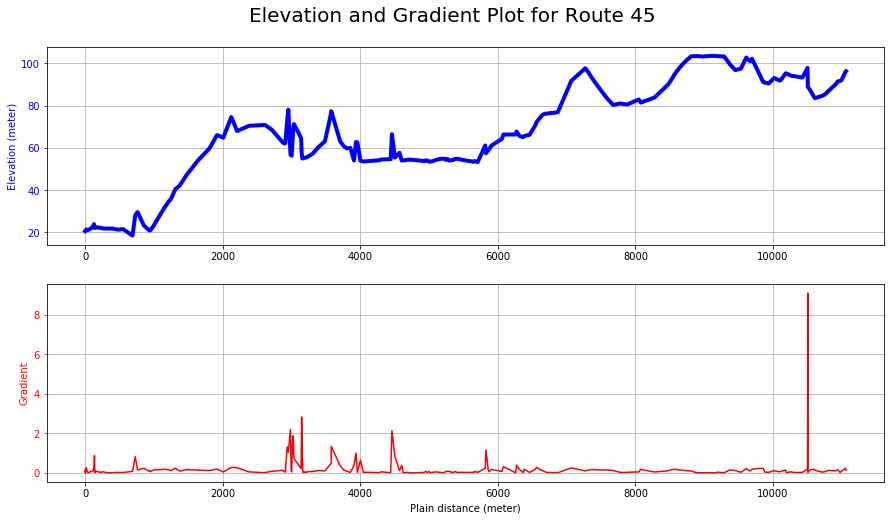

In [12]:
# route_to_shp(45,'../data/six_routes.shp','../data/sea_dtm_north.tif')
shapefile = '../data/six_routes.shp'
rasterfile = '../local_files/sea_north.tif'
# map_display, route_plot, route_diff_metrics = route_analysis(45, shapefile, rasterfile)
map_display, route_plot = route_analysis(45, shapefile, rasterfile)
map_display